In [1]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
import qiskit
import qiskit_ibm_provider

# qutritium
import utility as ut
import constant

# numerical
import numpy as np
import pickle 
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1
%config InlineBackend.figure_formats = ['svg']

In [2]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

In [3]:
rough_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value* constant.GHz
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/constant.GHz, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/constant.GHz, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6778 GHz


In [4]:
amp_sx12 = 0.25077166/2
beta_sx12 = -0.6032308412706848

In [5]:
with qiskit.pulse.build(backend=backend) as sched_sx12:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=64, amp=amp_sx12, sigma=16, beta=beta_sx12), drive_chan)
    
gate_sx12 = qiskit.circuit.Gate('SX12', weight, [])

ground_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(gate_sx12, [qubit], sched_sx12)

new_discrim = [ground_circ, first_excited_state_circ, second_excited_state_circ]

In [6]:
reset_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
reset_circuit.measure(qubit, cbit)

reset_circuits = [reset_circuit, reset_circuit]

# Rabi amplitude amplification protocol

In [7]:
with qiskit.pulse.build(backend=backend) as sched_drag_sx12:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=80, amp=amp_sx12, sigma=20, beta=beta_sx12), drive_chan)
    
gate_sx12 = qiskit.circuit.Gate('Rx12_90', weight, [])

RAA_circs_90_DRAG = []

for n in [2*i for i in range(20)]:
    amplitude_amplification_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    amplitude_amplification_circ.x(qubit)
    amplitude_amplification_circ.append(gate_sx12, [qubit])
    for i in range(n):
        amplitude_amplification_circ.append(gate_sx12, [qubit])
    amplitude_amplification_circ.measure(qubit, cbit)
    amplitude_amplification_circ.add_calibration(gate_sx12, [qubit], sched_drag_sx12)
    RAA_circs_90_DRAG.append(amplitude_amplification_circ)

In [8]:
RAA_package = new_discrim + RAA_circs_90_DRAG + reset_circuits

In [9]:
RAA_job = backend.run(RAA_package, meas_level=1, meas_return='single', shots=2048)

print(RAA_job.job_id())
print(RAA_job.status())

<JobStatus.QUEUED: 'job is queued'>

In [19]:
RAA90_job = provider.retrieve_job('crmwpah6kmd0008gqrp0')
RAA90_data = ut.DataAnalysis(experiment=RAA90_job, average=False, shots=2048, qubit=0)
RAA90_data.retrieve_data(average=False)
RAA90_data.build_discrim()
RAA90_data.count_pop()
RAA90_data.error_mitiq()

In [26]:
pop2_woDRAG = RAA90_data.mitiq_data[3:-2][0:20][:, 2]
pop2_wDRAG = RAA90_data.mitiq_data[3:-2][20:][:, 2]

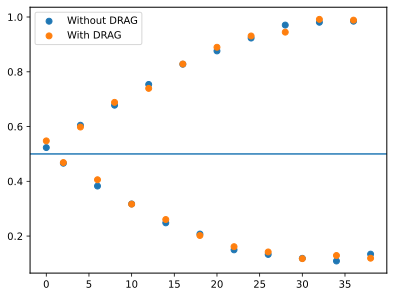

In [30]:
plt.scatter([2*i for i in range(20)], pop2_woDRAG, label='Without DRAG')
plt.scatter([2*i for i in range(20)], pop2_wDRAG, label='With DRAG')
plt.axhline(0.5)
plt.legend()